## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
url = 'https://lms.skillfactory.ru/assets/courseware/v1/c5e135f1dc26e5f342916b8ab78357f1/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/ab_data_tourist.zip'
data = pd.read_csv(url)
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


### **Признаки**

*user_id*	- идентификатор пользователя, зашедшего на сайт

*date*	- дата захода

*group*	- группа теста (контрольная — А или тестовая — B)

*purchase*	- признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет)

*price*	- цена купленного тура (если покупка не состоялась, цена равна 0)

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [5]:
data.date.dtypes

dtype('O')

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [169]:
data.date = pd.to_datetime(data.date)
print(f'Начало теста\n{data.groupby("group").date.min()}')
print(f'Конец теста\n{data.groupby("group").date.max()}')

Начало теста
group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]
Конец теста
group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [7]:
print(f'Количество посещений сайта\n{data.groupby("group").purchase.count()}')
print(f'Суммарное количество покупок\n{data.groupby("group").purchase.sum()}')
print(f'Сумма всех покупок, млн. руб.\n{data.groupby("group").price.sum()/1e6} ')

Количество посещений сайта
group
A    147202
B    147276
Name: purchase, dtype: int64
Суммарное количество покупок
group
A    17723
B    17514
Name: purchase, dtype: int64
Сумма всех покупок, млн. руб.
group
A    1436.26
B    1554.10
Name: price, dtype: float64 


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [8]:
set_a = set(data[data.group == 'A'].user_id)
set_b = set(data[data.group == 'B'].user_id)
user_intersection = set_a.intersection(set_b)
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [9]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

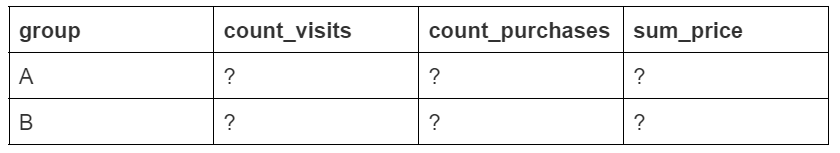
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [10]:
# вариант 1
agg_data = updated_data.groupby('group').agg({'purchase': ('count', 'sum'), 'price': 'sum'}).reset_index('group')
agg_data.columns = ['group', 'count_visits', 'count_purchases', 'sum_price']
agg_data

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


In [11]:
# вариант 2

data_agg = pd.DataFrame(
    {
    'group': updated_data.groupby("group").purchase.count().index,
    'count_visit': updated_data.groupby("group").purchase.count().values
    }
)
data_agg['count_purchases'] = updated_data.groupby("group").purchase.sum().values
data_agg['sum_price'] = updated_data.groupby("group").price.sum().values
data_agg

,group,count_visit,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество уникальных, в связи с тем, что на предыдущем этапе исключены те, кто посетил оба варианта страницы, посетителей в контрольной и тестовой группе практически равно

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [142]:
data_agg['conversion'] = round(data_agg.count_purchases/data_agg.count_visit*100, 2)
data_agg['mean_check'] = round(data_agg.sum_price/data_agg.count_purchases)

print(f'Конверсия в группе А равна {data_agg.conversion[0]} %')
print(f'Конверсия в группе B равна {data_agg.conversion[1]} %')
print(f'Средний чек в группе А равен {int(data_agg.mean_check[0])} рублей')
print(f'Средний чек группе B равен {int(data_agg.mean_check[1])} рублей')


Конверсия в группе А равна 12.03 %
Конверсия в группе B равна 11.89 %
Средний чек в группе А равен 81076 рублей
Средний чек группе B равен 88665 рублей


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

По числовым значениям метрик при переходе на варианта В конверсия сайта ухудшится, но при этом вырастет средний чек 

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [27]:
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [80]:
# Количество покупок туров без учёта пользователей, увидивших оба варианта сайта,
# распределяем по группам и цене, исключив данные о посещениях сайта без активного действия 
group_data = updated_data[updated_data.price != 0].groupby(['group', 'price']).purchase.count().reset_index()
group_data

,group,price,purchase
0,A,10000,5182
1,A,60000,5271
2,A,100000,1832
3,A,150000,3478
4,A,200000,1724
5,B,10000,5201
6,B,60000,1730
7,B,100000,5227
8,B,150000,3438
9,B,200000,1694


In [81]:
pivot_data = group_data.pivot_table(
                values='purchase',
                index='group',
                columns='price',
                aggfunc='mean',
                fill_value=0
)
pivot_data

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Количество проданных туров за 60000 рублей (в Турцию) в группе А равно 5271
Количество проданных туров за 60000 рублей (в Турцию) в группе В равно 1730


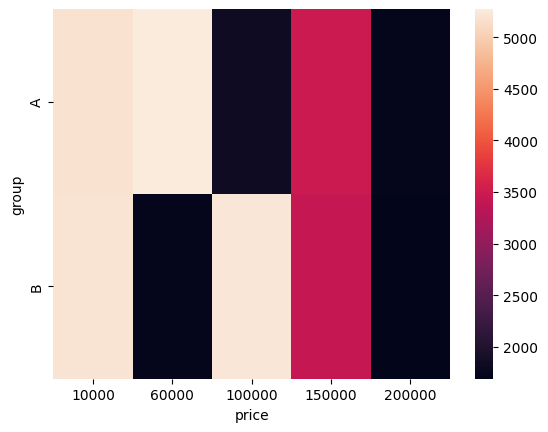

In [102]:
sns.heatmap(pivot_data);
print(f"Количество проданных туров за 60000 рублей (в Турцию) в группе А равно {pivot_data.iloc[:, 1][0]}")
print(f"Количество проданных туров за 60000 рублей (в Турцию) в группе В равно {pivot_data.iloc[:, 1][1]}")

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Участники контрольной группы существенно больше, чем участники тестовой группы, предпочитают поездки в Турцию и, наоборот, существенно реже покупают туры в Таиланд. По остальным направлениям предпочтения групп А и В совпадают.  

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [146]:
daily_data = updated_data.groupby(['date', 'group']).agg({'purchase': ('count', 'sum'), 'price': 'sum'}).reset_index()
daily_data.columns = ['date', 'group', 'count_visits', 'count_purchases', 'sum_price']
daily_data['conversion'] = daily_data.count_purchases/daily_data.count_visits
daily_data['mean_check'] = daily_data.sum_price/daily_data.count_purchases

mask_day = daily_data.date == '2021-01-03'

print(f'Ежедневная конверсия в группе А 3 января 2021 года равна {round(daily_data[mask_day].conversion.iloc[0]*100, 2)} %')
print(f'Ежедневная конверсия в группе В 3 января 2021 года равна {round(daily_data[mask_day].conversion.iloc[1]*100, 2)} %')
print(f'Ежедневный средний чек в группе А 3 января 2021 года равен {int(round(daily_data[mask_day].mean_check.iloc[0]))} рублей')
print(f'Ежедневный средний чек группе B 3 января 2021 года равен {int(round(daily_data[mask_day].mean_check.iloc[1]))} рублей')

# daily_data

Ежедневная конверсия в группе А 3 января 2021 года равна 11.34 %
Ежедневная конверсия в группе В 3 января 2021 года равна 11.39 %
Ежедневный средний чек в группе А 3 января 2021 года равен 82888 рублей
Ежедневный средний чек группе B 3 января 2021 года равен 87480 рублей


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [159]:
daily_data['cum_count_visits'] = daily_data.groupby(['group'])['count_visits'].cumsum()
daily_data['cum_count_purchases'] = daily_data.groupby(['group'])['count_purchases'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby(['group'])['sum_price'].cumsum()

# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_count_purchases']/daily_data['cum_count_visits']
# вычисляем комулятивный средний чек
daily_data['cum_mean_check'] = daily_data['cum_sum_price']/daily_data['cum_count_purchases']

print(f'Кумулятивная конверсия в группе В 20 января 2021 года равна \
{round(daily_data[daily_data.date == "2021-01-20"].cum_conversion.iloc[1]*100, 2)} %')
print(f'Кумулятивный средний чек в группе А 12 января 2021 года равен \
{int(round(daily_data[daily_data.date == "2021-01-12"].cum_mean_check.iloc[0]))} рублей')


Кумулятивная конверсия в группе В 20 января 2021 года равна 11.9 %
Кумулятивный средний чек в группе А 12 января 2021 года равен 81492 рублей


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

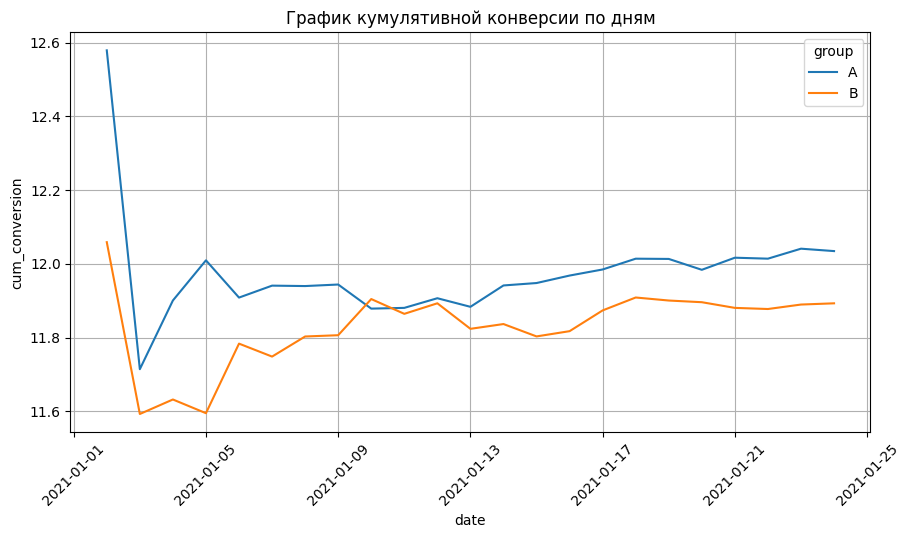

In [151]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

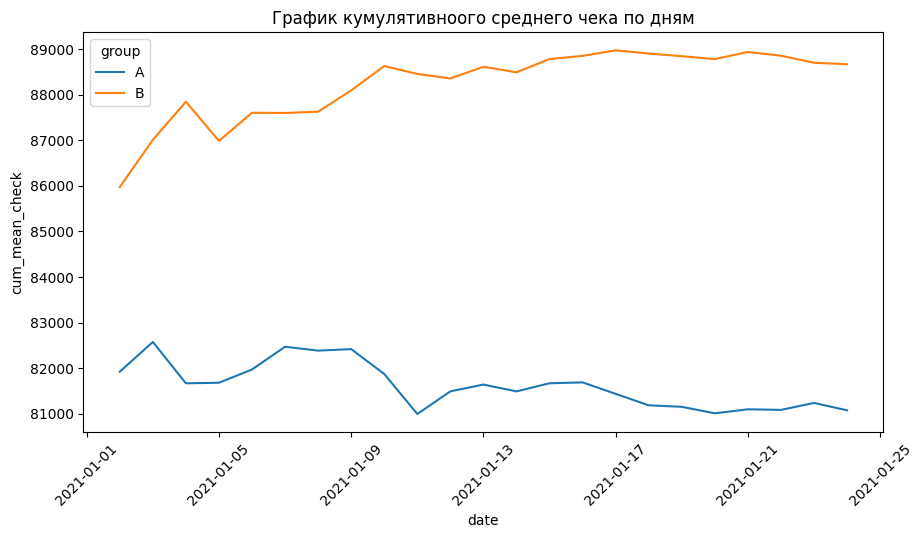

In [152]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивноого среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45);

**Выводы:**

Визуализация значений кумулятивных конверсии и среднего чека по сути подтверждают выводы, сделанные в предыдущих заданиях, - изменение сайта не улучшит коверсию, но существенно повысит средний чек. При этом графики показывают, что практически с середины теста (13 января 2021 года) наблюдается стабилизация данных метрик, что позволяет признать длимтельность теста достаточной.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [165]:
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [167]:
purchase_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(purchase_piv)

,sum,count
group,,
A,17487,145307
B,17290,145381


In [168]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=purchase_piv['sum'], #число "успехов"
    nobs=purchase_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

**Выводы:**

Для опеределения статистической разницы был применён z-тест (метод proportions_ztest() из билиотеки statsmodel), так как сравниваются конверсии (пропорции) по двум выборкам, а число наблюдений достаточно велико. При этом p-value превысил уровень значимости, селдовательно мы не можем отвергнуть нулевую гипотеза, а значит стаистическая разница между коверсиями в группе А и в группе В отсуствует.    

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [19]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

ваши выводы здесь

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
# ваш код здесь

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
# ваш код здесь

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

ваши выводы здесь

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
# ваш код здесь

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

ваши выводы здесь

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 